In [1]:
import theme
theme.load_style()

In [1]:
import numpy as np
import sympy as sp
%pylab inline
sp.init_printing("latex")

Populating the interactive namespace from numpy and matplotlib


# Lesson 16: The Method of Manufactured Solutions

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a>

This lecture by Tim Fuller is licensed under the
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  All code examples are also licensed under the [MIT license](http://opensource.org/licenses/MIT).

# Validation and Verification

## Validation Question
How do we know if the equations we have been solving are the right equations?

* Compare with data or with more sophisticated models.

## Verification Question
How do we know that we are solving the equations right?

* Compare the approximate solution with an exact solution whenever possible.  Otherwise, perform a variety of "sanity checks".  One such sanity check is the method of manufactured solutions.

# Method of Manufactured Solutions (MMS)

The method of manufactured solutions is a straightforward, yet powerful, method to verify that the finite element equations are being solved correctly.  In the MMS, we start with a "manufactured solution" $u$ and determine the form of the sourcing functions required to produce the solution by applying the governing equations to it.  The sourcing functions are then applied to the code and solution checked.

For example, consider the following boundary value problem

$$
\frac{d\sigma}{dx} + b = 0
$$
$$u(0) = 0$$
$$\sigma(L)=0$$

Let $\sigma = E\epsilon$ (linear elasticity) and suppose $u = f(x)$.  Applying the governing equations to $u$ we get

$$
\frac{d\sigma}{dx} + b = E\frac{d^2f}{dx^2} + b = 0 
\quad \longrightarrow \quad b = -E\frac{d^2f}{dx^2}
$$

Enforcing boundary conditions supplies additional constraints on $f$:

$$f(0) = 0$$
$$E\frac{df}{dx}=0$$

Other constraints (as needed) can be imposed on $f$.

## Example

Let $u = u_0 + u_1 \cos{\pi x^2} + u_2 \sin{\pi x^4}$.  The boundary conditions require that

$$u(0) = u_0 + u_1 \cos 0 + u_2 \sin 0 = 0$$
$$\sigma(L) = E\frac{du}{dx} = 
E\left(u_0 - u_1 2x\pi\sin{\pi x^2} + u_2 4x^3\sin{\pi x^4}\right) = 0$$

We have two equations, but three unknowns.  We choose the third equation by arbitrarily scaling the displacement at L to 1

$$u(L) = u_0 + u_1 \cos{\pi L^2} + u_2 \sin{\pi L^4} = 1$$

We solve the preceding equations below using sympy

In [6]:
# Manufactured solution
uL = 1
x, L, b, s, E = sp.symbols("x L b sigma E")
u0, u1, u2 = sp.symbols("u0 u1 u2")
a = u0 + u1 * x ** 2 + u2 * x ** 3
eps = sp.diff(a, x)
sig = E * eps * (eps + 2.) / (2. * eps + 2.)
coeffs = sp.solve([a.subs(x, 0), sig.subs(x, L), a.subs(x, L) - uL], 
                  (u0, u1, u2))
coeffs = dict(zip((u0, u1, u2), coeffs[0]))
u = a.subs(coeffs)
eps = u.diff(x)
sig = E * eps * (eps + 2.) / (2. * eps + 2.)
b = -sig.diff(x)

Yuck!  We now use the $b$ previously determined as an input to ezfem to verify that we get back the manufactured solution $u$.

-6.00000000000000


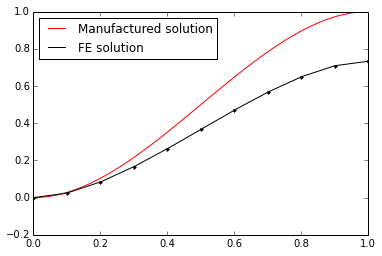

In [7]:
# Finite element model
import ezfem
reload(ezfem)
num_el = 10
length = 1
elem_name = "Link2"
mat_name = "neo"
mat_name = "elas"
mat_props = [1]
model = ezfem.FEModel.create_uniform(num_el, length, elem_name, mat_name, mat_props,
                                     solver="ite")
model.assign_bc("ilo", "essential", 0)

# use b from MMS
q = lambda arg: b.subs({x: arg, L: length, E: mat_props[0]}).evalf()
print q(0)
model.assign_distributed_load(q)
model.solve()

# Plot of FE model and analytic
f = lambda xx, ll: u.subs({x: xx, L: ll}).evalf()
xvals = np.linspace(0, 1)
yvals = [f(_, length) for _ in xvals]
plot(xvals, yvals, "r-", label="Manufactured solution")
xvals, yvals = model.interpolated_displacements()
plot(xvals, yvals, "k-", label="FE solution")
plot(model.coords, model.disp, "k.")
legend(loc="best")

# L2 norm error
def l2_norm_error(y1, y2, x):
    from math import sqrt
    return sqrt(np.sum([np.trapz((y1 - y2) ** 2, x)]))

ana_disp = np.array([f(_, length) for _ in model.coords])
error = l2_norm_error(model.disp, ana_disp, model.coords)
error

In [37]:
error

# Application to Class Project
In the class project, you are asked to verify your nonlinear FE code with MMS.  In our code, we solve

$$
\frac{d\sigma}{dx} + b = 0
$$

where 

$$
\sigma = \frac{E}{2}\left(\lambda - \frac{1}{\lambda}\right)
$$

To obtain the derivative $\frac{d\sigma}{dx}$, as required, use the chain rule:

$$
\frac{d\sigma}{dx} = \frac{d\sigma}{d\lambda}\frac{d\lambda}{du}\frac{du}{dx}
$$